In [ ]:
PLAN:

1) MRI data formats
2) accessing data voxel and meta data
3) transformations
4) preprocessing
5) visualization


In [1]:
from pydicom.data import get_testdata_files
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline


# MRI data analysis, sources databases, tools and QC

## 1) Medical Imaging File Formats 

All volume-based formats store 3D or 4D arrays of voxels in some fashion with a variety of additional meta-data. Anatomical images are typically 3D while EPIs are typically 4D (x,y,z, and time).

All volume files contain both meta-data and voxels. The meta-data is just a set of information about the file’s contents while the voxels are a 3D or 4D array of values.

Here are the most typical file formats of neuroimaging data:
1) DICOM (.dcm, .ima) \
2) NIFTI (.nii/nii.gz) \
3) MGH (.mgh, .mgz)

### Accessing voxel data

In [21]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline


#### DICOM file format

In [22]:
import nibabel as nib
import pydicom
from glob import glob
import os
import numpy as np


In [63]:
dcm_path = './data/DICOM/PA000000/ST000000/SE000000'
g = glob(dcm_path + '/*')
!tree ./data/DICOM --filelimit 2
# Print out the first 5 file names to verify we're in the right folder.
print('Total of %d DICOM images.\nFirst 5 filenames:' % len(g))
print('\n'.join(g[:5]))
print('Standart directory of DICOM:')



./data/DICOM
└── PA000000
    └── ST000000
        └── SE000000 [192 entries exceeds filelimit, not opening dir]

3 directories, 0 files
Total of 192 DICOM images.
First 5 filenames:
./data/DICOM/PA000000/ST000000/SE000000/img_138.dcm
./data/DICOM/PA000000/ST000000/SE000000/img_019.dcm
./data/DICOM/PA000000/ST000000/SE000000/img_139.dcm
./data/DICOM/PA000000/ST000000/SE000000/img_145.dcm
./data/DICOM/PA000000/ST000000/SE000000/img_075.dcm
Standart directory of DICOM:


Dimension of one dcm file: (256, 192)


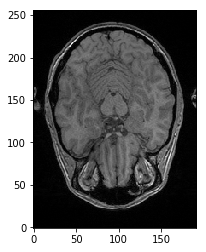

In [24]:
#Plot single dcm file
dcm_file = pydicom.dcmread(dcm_path + '/img_075.dcm')
plt.imshow(dcm_file.pixel_array, cmap='gray', origin='lower')
rows = int(dcm_file.Rows)
cols = int(dcm_file.Columns)
print('Dimension of one dcm file:', dcm_file.pixel_array.shape)
#print(dcm_file.pixel_array.max())
plt.show()


In [25]:
def load_scan(path):
    slices = [pydicom.dcmread(dcm_path + '/' + s) for s in os.listdir(dcm_path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    
    image = np.stack([s.pixel_array for s in slices])
    return np.array(image)


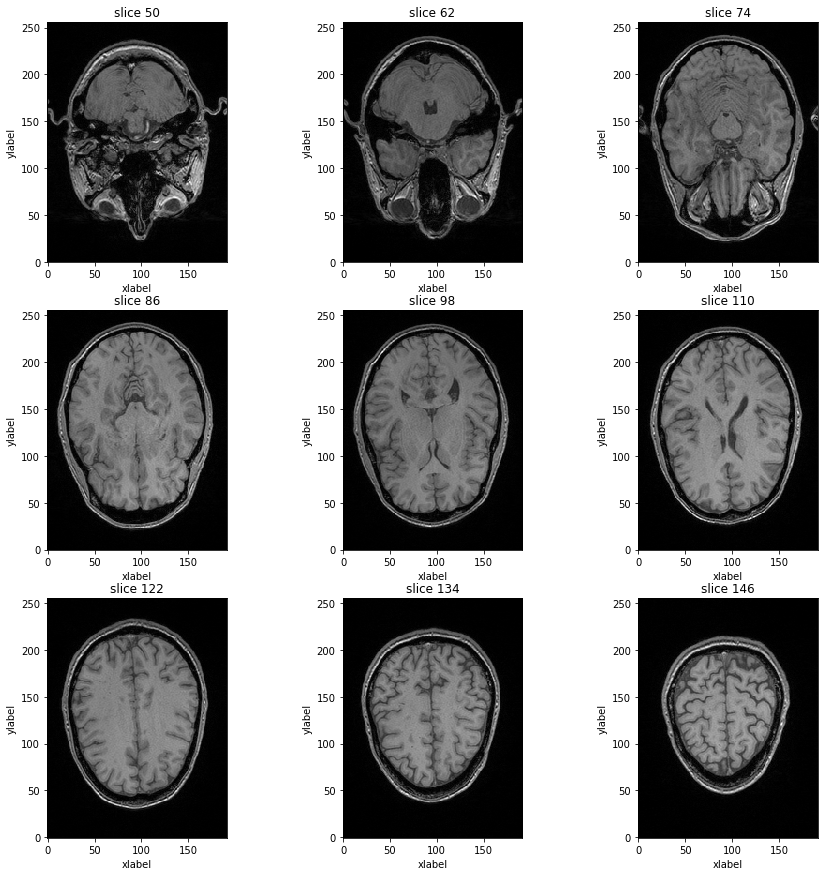

In [26]:
dcm_stack = load_scan(dcm_path)
rows=3
cols=3
start_with=50
show_every=12
fig,ax = plt.subplots(rows,cols,figsize=[15,15])
for i in range(rows*cols):
    ind = start_with + i*show_every
    ax[int(i/rows),int(i % rows)].imshow(dcm_stack[ind],cmap='gray', origin="lower")
    ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
    ax[int(i/rows),int(i % rows)].set_xlabel('xlabel')
    ax[int(i/rows),int(i % rows)].set_ylabel('ylabel')
plt.show()


In [27]:
import nibabel.freesurfer.mghformat as mgh
mgh_file = mgh.load('./data/fs_preproc/100206/mri/T1.mgz')
mgh_file.get_fdata().shape


(256, 256, 256)

In [28]:
nii_file = nib.load('./data/raw/100206/unprocessed/3T/T1w_MPR1/100206_3T_T1w_MPR1.nii.gz')
nii_file.get_fdata().shape


(256, 320, 320)

In [60]:
def show_slices(image, axis1="x", axis2="y", axis3="z"):
    slice_0 = image[round(len(image[0])/2), :, :]
    slice_1 = image[:, round(len(image[1])/2), :]
    slice_2 = image[:, :, round(len(image[2])/2)]
    image = ([slice_0, slice_1, slice_2])
    fig, axes = plt.subplots(1, len(image), figsize=[15,15])
    for i, slice in enumerate(image):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[0].set(xlabel=axis1, ylabel=axis2)
        axes[1].set(xlabel=axis1, ylabel=axis3)
        axes[2].set(xlabel=axis2, ylabel=axis3)
    plt.show()

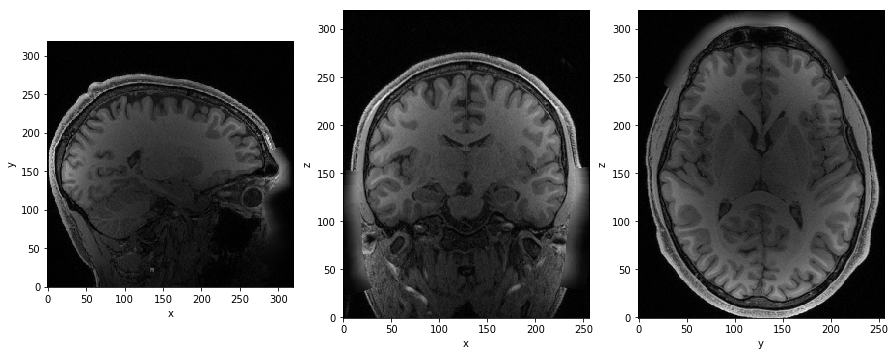

In [61]:
nii_image = np.array(nii_file.dataobj).astype(np.float64)
show_slices(nii_image)

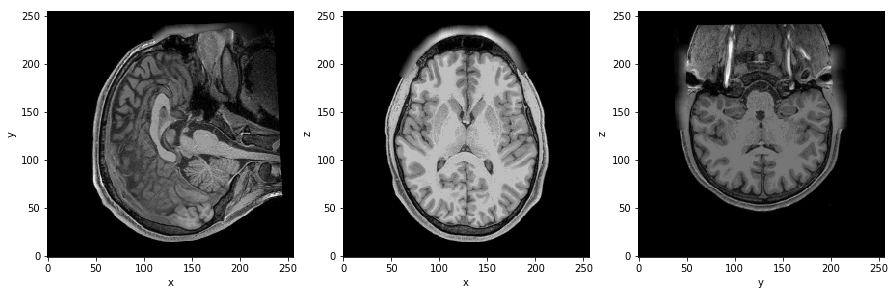

In [62]:
mgh_image = np.array(mgh_file.dataobj).astype(np.float64)
show_slices(mgh_image)

### Accessing meta data

Another good way to look at the meta-data in a volume file is to load it with the relevant programming environment and examine the data-structures there. Here are a few examples.

In [32]:
pat_name = dcm_file.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient id.......:", dcm_file.PatientID)
print("Modality.........:", dcm_file.Modality)
print("Rows.............:", dcm_file.Rows)
print("Columns..........:", dcm_file.Columns)
print("Pixel Spacing....:", dcm_file.PixelSpacing)
print("Slide Thickness.:", dcm_file.SliceThickness)
print("Patient Position.:", dcm_file.PatientPosition)


Patient id.......: 1010
Modality.........: MR
Rows.............: 256
Columns..........: 192
Pixel Spacing....: [1, 1]
Slide Thickness.: 1
Patient Position.: HFS


Accordingly, we need to be able to, at a minimum, store some amount of information about the coordinate system employed in any MRI volume file, and ideally some amount of information about how to precisely align the brain to some standard orientation.

In [33]:
#print(mgh_file.header)
mgh_header = mgh_file.header
print("Image dimensions........:", mgh_header['dims'])
print("Affine transformation...: "'\n', mgh_header.get_affine())


Image dimensions........: [256 256 256   1]
Affine transformation...: 
 [[-1.0000000e+00  1.8626451e-09 -4.0745363e-10  1.2723160e+02]
 [ 2.9103830e-10 -3.7252903e-09  1.0000001e+00 -8.1819077e+01]
 [ 1.8626451e-09 -1.0000000e+00  0.0000000e+00  1.3774704e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [34]:
nii_header = nii_file.header
print("Image dimensions...........................:", nii_header['dim'])
print("Voxel size and time interval...............:", nii_header['pixdim'])
print("Slice Order................................:", nii_header['slice_code'])
print("Human readable text........................:", nii_header['descrip'])
print("Three rows of sform affine transformation..:"'\n', nii_header['srow_x'],'\n', nii_header['srow_y'],'\n', nii_header['srow_z'])


Image dimensions...........................: [  3 256 320 320   1   1   1   1]
Voxel size and time interval...............: [-1.   0.7  0.7  0.7  2.4  0.   0.   0. ]
Slice Order................................: 0
Human readable text........................: b'FSL4.1'
Three rows of sform affine transformation..:
 [-6.99810445e-01 -1.05695827e-02 -1.23907495e-02  9.24809952e+01] 
 [-9.9054789e-03  6.9896263e-01 -3.6784306e-02 -5.8499706e+01] 
 [-1.2927809e-02  3.6599010e-02  6.9892299e-01 -1.0628173e+02]


In [ ]:
*Voxel size* and *Pixel spacing* are important as we for preprocessing we can use only isomorphic voxel

In [ ]:
Assume that you recieved new dicom from hospital and you need to convert to convinient NIFTI, let's review the tool distinctive from simple on above:

In [ ]:
!dcm2niix -o /workspace -f %i_%n_%p -z y /workspace/data/DICOM

In [ ]:
from nilearn.input_data import NiftiMasker
from nilearn import plotting
dcm_to_nii_convert = './1010_BRAIN_MR_T1_AX.nii.gz'
plot_convert = plotting.view_img(dcm_to_nii_convert,
                                 bg_img=False,
                                 cmap='gray',
                                 symmetric_cmap=False,
                                 threshold=0,
                                 title='Drag mouse to go through slices')
plot_convert